In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [2]:
# CHOOSE DATASET

# Binary classification dataset
diabetes = datasets.load_diabetes(as_frame=True)

# Regression dataset
#data = datasets.fetch_openml(name="boston",version=1, as_frame=True) 

X = diabetes.data.values
y = diabetes.target.values

print("Shape:", X.shape)

print(diabetes.data.head(), "\n \n")# first rows of features
print(diabetes.target.head()) # first rows of target

Shape: (442, 10)
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641   
 

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

A fixed seed was added to this code to ensure the reproducibility of the analysis. This allowed for manual tuning of the hyperparameters to achieve better model training.

In [5]:
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Para GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Tornar CUDA determinístico
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [7]:
num_epochs=190
lr=0.01
dropout=0.25
batch_size=128

This model was trained on the GPU and then transferred to the CPU for use with NumPy. Given the low number of parameters (i.e., the model's low complexity), the time required on the CPU was similar to that on the GPU.

In [8]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"  # force to use CPU
print(device)

cuda


In [9]:
Xtr = torch.tensor(Xtr, dtype=torch.float32).to(device)
ytr = torch.tensor(ytr, dtype=torch.float32).to(device)
Xte = torch.tensor(Xte, dtype=torch.float32).to(device)
yte = torch.tensor(yte, dtype=torch.float32).to("cpu")

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

The model was implemented as a fully connected neural network (MLP) with four hidden layers of 64 neurons each, using ReLU activation functions. The network takes the input features of the dataset and outputs a single value for regression (Diabetes Progression).

In [11]:
# Training loop
import time
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch [1/190], Loss: 29648.7161
Epoch [2/190], Loss: 27738.2480
Epoch [3/190], Loss: 19526.0052
Epoch [4/190], Loss: 10916.4779
Epoch [5/190], Loss: 7908.8825
Epoch [6/190], Loss: 6315.4227
Epoch [7/190], Loss: 6881.3011
Epoch [8/190], Loss: 5394.8262
Epoch [9/190], Loss: 5833.4985
Epoch [10/190], Loss: 4486.8579
Epoch [11/190], Loss: 4801.0705
Epoch [12/190], Loss: 4380.2632
Epoch [13/190], Loss: 4705.3464
Epoch [14/190], Loss: 4574.8371
Epoch [15/190], Loss: 4115.9676
Epoch [16/190], Loss: 4263.3736
Epoch [17/190], Loss: 4220.0199
Epoch [18/190], Loss: 3679.3091
Epoch [19/190], Loss: 3745.2568
Epoch [20/190], Loss: 3896.5340
Epoch [21/190], Loss: 4014.5900
Epoch [22/190], Loss: 3893.0127
Epoch [23/190], Loss: 3573.5227
Epoch [24/190], Loss: 3891.4432
Epoch [25/190], Loss: 3775.5807
Epoch [26/190], Loss: 3753.8115
Epoch [27/190], Loss: 3697.5588
Epoch [28/190], Loss: 3638.7832
Epoch [29/190], Loss: 4002.4415
Epoch [30/190], Loss: 3921.0071
Epoch [31/190], Loss: 3542.5956
Epoch [32/190

In [12]:
y_pred=model(Xte).cpu()  # só nesta altura volta ao CPU
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2814.833251953125


After tuning the hyperparameters, the best configuration was: num_epochs = 200, lr = 0.02, dropout = 0.2, and batch_size = 128.A dropout with a probability of 0.2 was applied after each layer to mitigate overfitting.It order to validate the model the MSE was computed. The model was evaluated using the Mean Squared Error (MSE), which resulted in a high value of 2815. This indicates that, despite the training and parameter optimization, the current approach is insufficient to accurately predict Diabetes Progression. The high error may be attributed to the limited size of the dataset, the low number of features. In comparison with previous approaches, such as ANFIS or TSK models, this approach exhibited the worst performance.

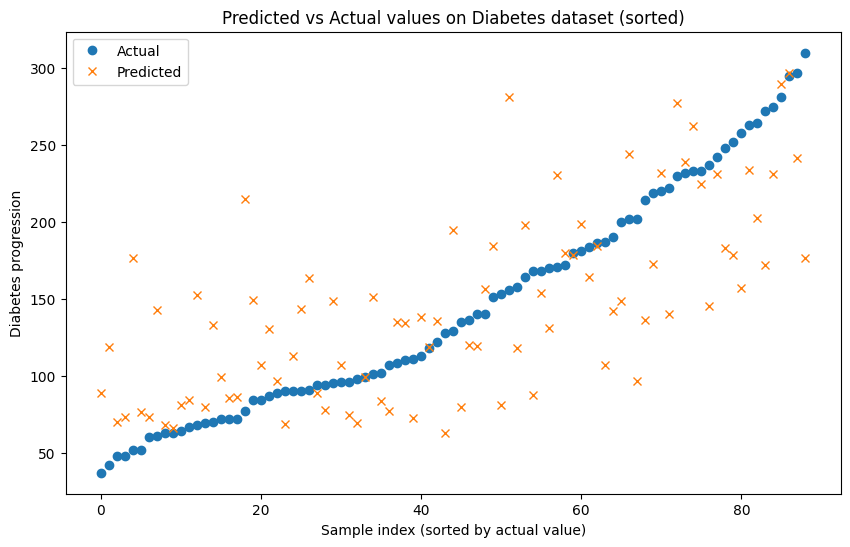

In [13]:
# Plot predictions vs actual
# Converter y_pred para numpy e flatten
y_pred_np = y_pred.detach().numpy().flatten()
yte_np = yte.detach().numpy()

# Obter índices que ordenam yte
sort_idx = np.argsort(yte_np)

# Ordenar yte e y_pred segundo esses índices
yte_sorted = yte_np[sort_idx]
y_pred_sorted = y_pred_np[sort_idx]

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(len(yte_sorted)), yte_sorted, label="Actual", marker="o", linestyle='')
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted", marker="x", linestyle='')

plt.xlabel("Sample index (sorted by actual value)")
plt.ylabel("Diabetes progression")
plt.title("Predicted vs Actual values on Diabetes dataset (sorted)")
plt.legend()
plt.show()